In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

import pickle

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import load_model

import copy

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('../bhaven/Tuned_logReg_all_training_data.pkl', 'rb') as file:  
    Logreg = pickle.load(file)

In [3]:
data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);
data_test = data_test.dropna()
data_train = data_train.dropna()
data_test = data_test[data_test.int_rate < 0.5]
data_train = data_train[data_train.int_rate < 0.5]

In [4]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 
                         'term_adj', 'zip_code']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)


def create_df(data_1, data_2, penal):
    df = pd.DataFrame(data_1)
    #df['proba'] = df.proba.map(lambda x: x[0])
    #df['pred'] = df.pred.map(lambda x:x[0])
    
    df['int_rate'] = data_2['int_rate']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term_adj'] = data_2['term_adj']
    df['ROI'] = (((1 + df['int_rate'])*(1-df['proba']))+(df['proba']*drr*penal))-1

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term_adj']))-1)
    df['annualized_amnt'] = df['amnt'] #*(1/df['term_adj'])
    
    df['zip_code'] = data_2['zip_code']
    
    return df

distress = data_train[data_train.paid == 1]
drr = (np.sum(distress.total_pymnt)/np.sum(distress.amnt))**(1/np.mean(distress.term))
print('Distressed Return Rate: ', drr)

Distressed Return Rate:  0.9002379720899713


In [89]:
train_data = {'proba' : Logreg.predict_proba(x_train)[:, 1], 'pred' : Logreg.predict(x_train), 'true_val' : y_train}
test_data = {'proba' : Logreg.predict_proba(x_test)[:, 1], 'pred' : Logreg.predict(x_test), 'true_val' : y_test}
Logreg_train = create_df(train_data, data_train, 0.5)
Logreg_test =  create_df(test_data, data_test, 0.5)

print('Training Accuracy: ', accuracy_score(Logreg_train.pred, Logreg_train.true_val))
print('Test Accuracy: ', accuracy_score(Logreg_test.pred, Logreg_test.true_val))

Training Accuracy:  0.6487395961929036
Test Accuracy:  0.7462018397316265


In [90]:
NN_train = pd.read_csv("NN_train.csv", low_memory=False, delimiter = '\t')
NN_test = pd.read_csv("NN_test.csv", low_memory=False, delimiter = '\t')

print('Training Accuracy: ', accuracy_score(NN_train.pred, NN_train.true_val))
print('Test Accuracy: ', accuracy_score(NN_test.pred, NN_test.true_val))

Training Accuracy:  0.6756686028319974
Test Accuracy:  0.780688875363807


/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


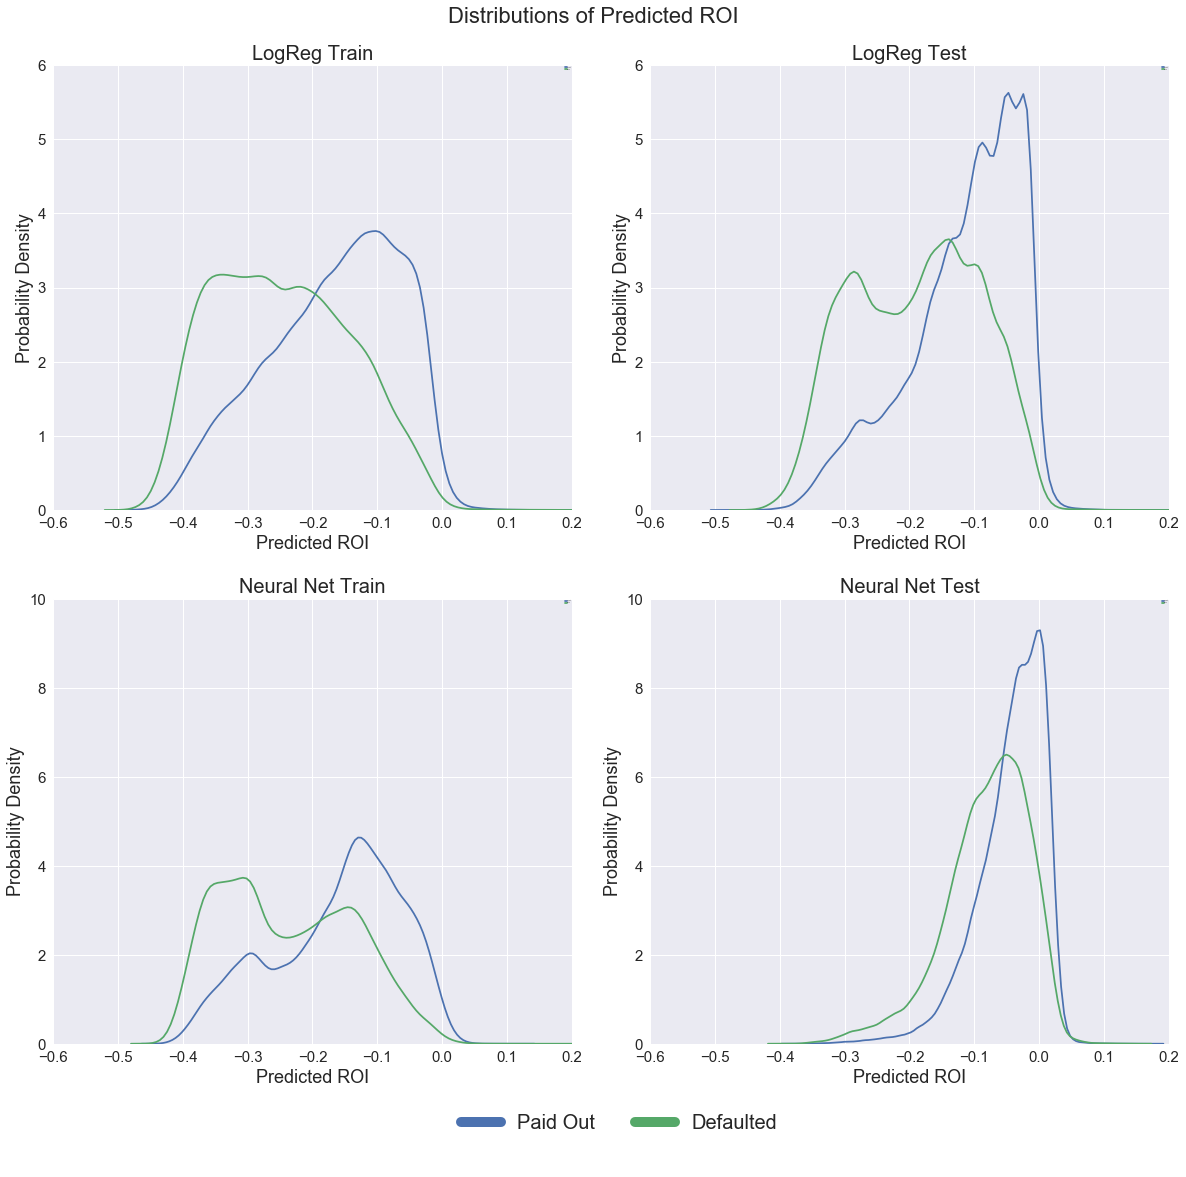

In [91]:
models = [Logreg_train, Logreg_test, NN_train, NN_test]
titles = ['LogReg Train', 'LogReg Test', 'Neural Net Train', 'Neural Net Test']
fig = plt.figure(figsize=(20, 18)) 
fig.subplots_adjust(hspace=0.2, wspace=0.15)
plt.suptitle('Distributions of Predicted ROI', size = 22,  y=0.925)

for n, model in enumerate(models):
    ax = plt.subplot(2,2, n+1)
    sns.kdeplot(model.loc[model.true_val == 0,'ROI'], label = 'Paid Out', ax=ax);
    sns.kdeplot(model.loc[model.true_val == 1,'ROI'], label = 'Defaulted', ax=ax);
    ax.set_xlim(-0.6, 0.2)
    if n <= 1:
        ax.set_ylim(0, 6)
    else:
        ax.set_ylim(0, 10)
        
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('Predicted ROI', fontsize = 18)
    ax.set_ylabel('Probability Density', fontsize = 18)
    ax.set_title('{0}'.format(titles[n]), fontsize = 20)
    ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.43, 0.02))
plt.show()

**Formulating ROI**

Having used several different models to assign probabilities of default to the loans in our training and test sets, we needed to incorporate these probabilities into our investment strategy. We decided to use these probabilities of default to calculate a Return on Investment (ROI) for every loan in the dataset. By only investing in the loans with the best predicted ROI, we would hope to achieve stronger returns than the broader market. 

Our formula for expected ROI was:

$$ ROI_{P}=\frac{[(1+I)(A)](1-P(d)) + \alpha P(d)(R) - A}{A} $$

Where $A$ refers to the Loan amount, $P(d)$ to the probability of default assessed by our classification models, $I$ to the interest rate charged on the loan being considered and $R$ the expected amount to be returned should a loan default. The predicted ROI is the expected return from all of our loans, so in the case when we don't expect loans to default ($1-P(d)$ of the time) we would receive $(1+I)A$ from the borrower. Should the borrower default we would expect to still receive some money from them: defaults rarely happen before any payments have been made, and because of charge-offs and other measures, on average, investors get back 89 cents on the dollar from their distressed loans. Since we want to bias our model away from investing in loans that might default (due to the large variance in recovery outcomes) we apply a penalty term, $\alpha$ = 0.5, so that the ROI's returned by our model are biased towards a subset of loans less likely to default than their peers. 

Using this formula we are able to predict ROI for every loan in our training and test sets. We then rank the loans according to predicted ROI, and invest only in the top tranche. Plots of initially predicted ROI across loans that eventually paid off or defaulted are shown above for both the Logistic Regression model and our Neural Net. 

**Market Efficiency**

We would expect the loan market to be very efficient, and to price a borrower's risk into their loan. We know this is the case, since riskier borrowers (by loan grade) need to pay higher interest rates to qualify for credit. Because our ROI formulation represents a balance between a borrowers risk of default, and the interest rate we are charging them, a fully efficient market wouldn't present us with opportunities to 'over-perform' since these two competing attributes would be expected to work against each other such that every loan had a similar predicted ROI. [Lending Club](https://blog.lendingclub.com/next-wave-innovation-marketplace-lending/) claims to have been founded on the premise that a peer-to-peer lending model would work to make small loans more efficient by making them accessible to large investors. Large institutional investors increasingly use the Lending Club platform as a way to diversify their investments, making this a tough market place to compete in as an individual.

**Comparison of Models**

Our investment strategy relied on being able to predict ROI for loans, and for those loans to then perform as expected. From the plot above, showing ROI distributions for the Logistic Regression model and the Neural Net model, we can see that the best split in the proposed distributions was for the Logistic Regression model. We decided to use this model as the base for our final investment simulation, where we would predict a subset of loans we ought to invest in going forwards in 2015, and then we would compare the performance of this subset with the performance of the general market come the end of the loan life. 

In [127]:
Logreg_train.describe()

,proba,pred,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt,cumsum_prop_loans,cumsum_ROI
count,3.515540e+05,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000,351554.000000
mean,4.549942e-01,0.407090,0.177865,0.139426,14543.612503,16029.595814,2.492153,0.023780,784.880101,14543.612503,0.469807,0.057293
std,1.820300e-01,0.491293,0.382399,0.043914,8275.289772,10444.596448,1.215896,0.027617,1888.983869,8275.289772,0.277187,0.004862
min,9.065135e-12,0.000000,0.000000,0.060000,1000.000000,0.000000,0.040000,-0.072292,-30375.000000,1000.000000,0.000007,0.053753
25%,3.131555e-01,0.000000,0.000000,0.109900,8000.000000,8122.477500,1.583333,0.005752,366.332298,8000.000000,0.234856,0.054317
50%,4.477887e-01,0.000000,0.000000,0.136700,12550.000000,13459.249275,2.833333,0.029809,813.565428,12550.000000,0.460015,0.055160
75%,5.961397e-01,1.000000,0.000000,0.167800,20000.000000,21872.552985,3.000000,0.043683,1532.944068,20000.000000,0.690198,0.058446
max,9.160920e-01,1.000000,1.000000,0.260600,35000.000000,62884.797380,5.500000,0.212230,17306.592856,35000.000000,1.000000,0.162442


In [86]:
NN_train = NN_train.sort_values(by=['ROI'], ascending=False)
NN_test = NN_test.sort_values(by=['ROI'], ascending=False)
Logreg_train = Logreg_train.sort_values(by=['ROI'], ascending=False)
Logreg_test = Logreg_test.sort_values(by=['ROI'], ascending=False)

def create_strategy_curve(df):
    df['cumsum_prop_loans'] = df.amnt.cumsum()/np.sum(df.amnt)
    df['cumsum_ROI'] = df.Real_ROI.cumsum()/df.annualized_amnt.cumsum()
    return df

NN_train = create_strategy_curve(NN_train)
NN_test = create_strategy_curve(NN_test)
Logreg_train = create_strategy_curve(Logreg_train)
Logreg_test = create_strategy_curve(Logreg_test)

In [129]:
Logreg_test

,proba,pred,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt,zip_code,cumsum_prop_loans,cumsum_ROI
283350,5.485650e-02,0,1,0.2499,35000.0,14684.030000,5.000000,0.230719,-5581.299283,35000.0,631xx,0.000007,-0.159466
155484,5.602431e-07,0,0,0.1999,35000.0,49084.223494,2.416667,0.199900,5257.188690,35000.0,064xx,0.000014,-0.004630
167647,4.617924e-02,0,1,0.1999,10000.0,2902.680000,5.000000,0.186062,-2191.639926,10000.0,064xx,0.000016,-0.031447
68722,7.849326e-04,0,1,0.1855,18000.0,9917.950000,5.000000,0.185276,-2022.736895,18000.0,370xx,0.000019,-0.046311
22801,1.010504e-03,0,1,0.1757,21000.0,16338.470000,5.000000,0.175422,-1028.176801,21000.0,330xx,0.000023,-0.046779
236603,2.401762e-01,0,0,0.2580,35000.0,41481.110000,0.750000,0.172074,8897.974059,35000.0,064xx,0.000030,0.021632
23201,6.279075e-02,0,0,0.1820,14000.0,19423.635123,2.583333,0.164308,1891.838950,14000.0,802xx,0.000033,0.031090
108596,7.047232e-02,0,0,0.1825,32000.0,38615.184415,1.333333,0.162608,4843.092760,32000.0,750xx,0.000039,0.050331
39303,1.890705e-01,0,0,0.2199,31050.0,31618.650000,0.083333,0.159461,7554.881967,31050.0,600xx,0.000045,0.076265
279559,6.664501e-02,0,0,0.1757,17000.0,20099.940000,1.083333,0.157342,2842.615969,17000.0,721xx,0.000049,0.082498


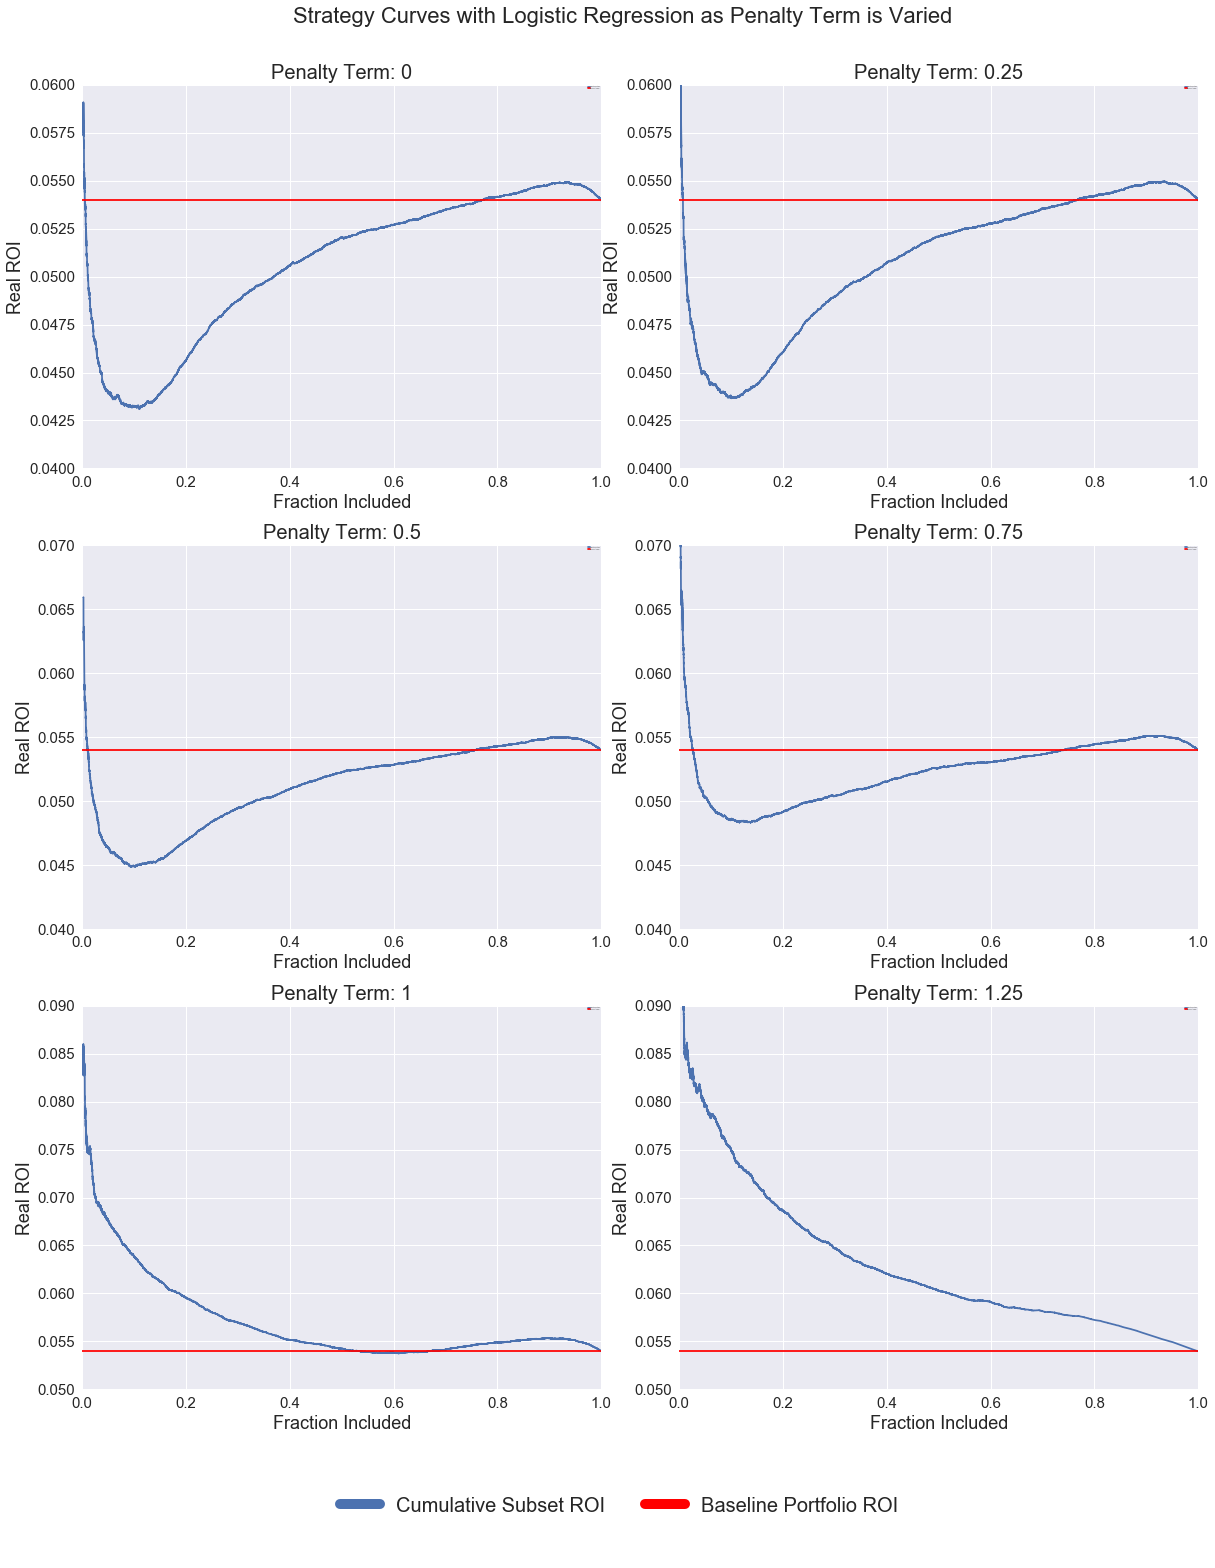

In [102]:
fig = plt.figure(figsize=(20, 24)) 
fig.subplots_adjust(hspace=0.2, wspace=0.15)
plt.suptitle('Strategy Curves with Logistic Regression as Penalty Term is Varied', size = 22,  y=0.925)


penals = [0, 0.25, 0.5, 0.75, 1, 1.25]
i = 500

for n, penal in enumerate(penals):
    Logreg_train_penal = create_df(train_data, data_train, penal)
    Logreg_train_penal = Logreg_train_penal.sort_values(by=['ROI'], ascending=False)
    Logreg_train_penal = create_strategy_curve(Logreg_train_penal)
    
    ax = plt.subplot(3,2, n+1)
    plt.plot(Logreg_train_penal.cumsum_prop_loans[i:], Logreg_train_penal.cumsum_ROI[i:], label = 'Cumulative Subset ROI')
    plt.axhline(np.sum(Logreg_train_penal.Real_ROI)/np.sum(Logreg_train_penal.annualized_amnt), color = 'r', label = 'Baseline Portfolio ROI')
    ax.set_xlim(0,1)
    if n <= 1:
        ax.set_ylim(0.04, 0.06)
    elif n <= 3 and n > 1:
        ax.set_ylim(0.04, 0.07)
    else:
        ax.set_ylim(0.05, 0.09)
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('Fraction Included', fontsize = 18)
    ax.set_ylabel('Real ROI', fontsize = 18)
    ax.set_title('Penalty Term: {0}'.format(penal), fontsize = 20)
    ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.43, 0.02))
plt.show()

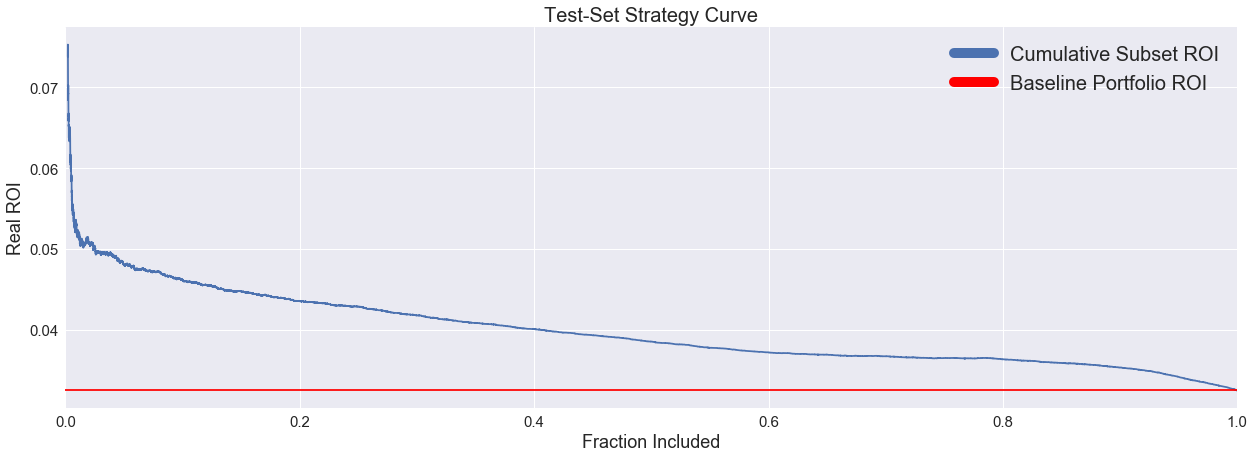

In [124]:
Logreg_train = create_df(train_data, data_train, 1)
Logreg_test =  create_df(test_data, data_test, 1)
Logreg_train = Logreg_train.sort_values(by=['ROI'], ascending=False)
Logreg_test = Logreg_test.sort_values(by=['ROI'], ascending=False)
Logreg_train = create_strategy_curve(Logreg_train)
Logreg_test = create_strategy_curve(Logreg_test)

fig = plt.figure(figsize=(21, 7)) 

i = 500
plt.plot(Logreg_test.cumsum_prop_loans[i:], Logreg_test.cumsum_ROI[i:], label = 'Cumulative Subset ROI')
plt.axhline(np.sum(Logreg_test.Real_ROI)/np.sum(Logreg_test.annualized_amnt), color = 'r', 
            label = 'Baseline Portfolio ROI')

plt.xlim(0,1)
plt.tick_params(labelsize = 15)
plt.xlabel('Fraction Included', fontsize = 18)
plt.ylabel('Real ROI', fontsize = 18)
plt.title('Test-Set Strategy Curve', fontsize = 20)
plt.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
plt.legend(handles, labels, loc='upper right', ncol = 1, fontsize = 20)
plt.show()

**Analysis**

Having predicted ROI for all the loans in our training and test sets, we rearrange the dataframes to rank loans based on this metric. The strategy curves show us the ROI we would achieve if we invested in all the loans in the portfolio working our way down the ranked list from best to worst. The result for the test set is very clear cut, we would have achieved better than average returns as we work down the list.

Our strategy curve with the training data is less clear cut, 

In [ ]:
Logistic_re